In [1]:

import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
import ast
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import SVDpp, accuracy
from surprise.model_selection import cross_validate
from collections import defaultdict
from surprise import SVD, SVDpp, NMF
from surprise import SlopeOne, CoClustering
import ml_metrics as metrics
from sklearn.metrics import dcg_score
from sklearn.metrics import ndcg_score
import json
import pickle

In [2]:
dataset = pd.read_csv('2019-oct.csv')
dataset.head()

,Unnamed: 0,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [3]:
dataset.tail()

,Unnamed: 0,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
6310400,6310400,2019-10-05 23:59:57 UTC,view,6400313,2053013554121933129,computers.components.cpu,intel,177.48,546038044,b8338d61-1101-4817-88dc-b29f00ca355c
6310401,6310401,2019-10-05 23:59:58 UTC,view,9300047,2053013554524586339,NaN,sony,334.35,515801257,4e59332f-a72c-4c88-a178-4646ba1da5b3
6310402,6310402,2019-10-05 23:59:58 UTC,view,4501043,2053013563877884791,appliances.kitchen.hob,hansa,205.41,515945416,ccc1c808-4f60-406f-a6da-a8742ce4d6ba
6310403,6310403,2019-10-05 23:59:59 UTC,view,5100627,2053013553341792533,electronics.clocks,garmin,169.86,520207634,5c98cfe2-9670-49e4-811f-419bef2720fe
6310404,6310404,2019-10-05 23:59:59 UTC,view,2601529,2053013563970159485,NaN,redmond,48.63,557193760,fdc7f7ca-10dc-467d-a963-8a65397bf4e6


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6310405 entries, 0 to 6310404
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Unnamed: 0     int64  
 1   event_time     object 
 2   event_type     object 
 3   product_id     int64  
 4   category_id    int64  
 5   category_code  object 
 6   brand          object 
 7   price          float64
 8   user_id        int64  
 9   user_session   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 481.4+ MB


In [5]:
dataset.drop(['Unnamed: 0'],axis=1, inplace =True)

In [6]:
dataset.dropna(axis=0, how='any', inplace=True)

In [7]:
dataset.isnull().sum()

event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64

<h3>Chỉ sử dụng nhóm sản phẩm smartphone để tính toán nhanh do dữ liệu khá lớn</h3>

In [8]:
df= dataset[dataset['category_code']=="electronics.smartphone"][:300000]
df.shape

(300000, 9)

In [9]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d
9,2019-10-01 00:00:11 UTC,view,1004545,2053013555631882655,electronics.smartphone,huawei,566.01,537918940,406c46ed-90a4-4787-a43b-59a410c1a5fb
11,2019-10-01 00:00:11 UTC,view,1005011,2053013555631882655,electronics.smartphone,samsung,900.64,530282093,50a293fb-5940-41b2-baf3-17af0e812101
19,2019-10-01 00:00:19 UTC,view,1005135,2053013555631882655,electronics.smartphone,apple,1747.79,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d
20,2019-10-01 00:00:20 UTC,view,1003306,2053013555631882655,electronics.smartphone,apple,588.77,555446831,6ec635da-ea15-4a5d-96b4-c8ca9d38f89f


In [10]:
df.dtypes

event_time        object
event_type        object
product_id         int64
category_id        int64
category_code     object
brand             object
price            float64
user_id            int64
user_session      object
dtype: object

<h4>Convert data type.</h4>

In [11]:
#df['event_time']= pd.to_datetime(df['event_time']).dt.tz_convert(None)
df['category_id']=df['category_id'].astype('object')
df['product_id']=df['product_id'].astype('object')
df['user_id']=df['user_id'].astype('object')



In [41]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,levels
0,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,1
1,2019-10-01 00:00:11 UTC,view,1004545,2053013555631882655,electronics.smartphone,huawei,566.01,537918940,406c46ed-90a4-4787-a43b-59a410c1a5fb,1
2,2019-10-01 00:00:11 UTC,view,1005011,2053013555631882655,electronics.smartphone,samsung,900.64,530282093,50a293fb-5940-41b2-baf3-17af0e812101,1
3,2019-10-01 00:00:19 UTC,view,1005135,2053013555631882655,electronics.smartphone,apple,1747.79,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,1
4,2019-10-01 00:00:20 UTC,view,1003306,2053013555631882655,electronics.smartphone,apple,588.77,555446831,6ec635da-ea15-4a5d-96b4-c8ca9d38f89f,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 4 to 1105426
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     300000 non-null  object 
 1   event_type     300000 non-null  object 
 2   product_id     300000 non-null  object 
 3   category_id    300000 non-null  object 
 4   category_code  300000 non-null  object 
 5   brand          300000 non-null  object 
 6   price          300000 non-null  float64
 7   user_id        300000 non-null  object 
 8   user_session   300000 non-null  object 
dtypes: float64(1), object(8)
memory usage: 22.9+ MB


In [13]:
df.reset_index(inplace=True, drop=True)
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d
1,2019-10-01 00:00:11 UTC,view,1004545,2053013555631882655,electronics.smartphone,huawei,566.01,537918940,406c46ed-90a4-4787-a43b-59a410c1a5fb
2,2019-10-01 00:00:11 UTC,view,1005011,2053013555631882655,electronics.smartphone,samsung,900.64,530282093,50a293fb-5940-41b2-baf3-17af0e812101
3,2019-10-01 00:00:19 UTC,view,1005135,2053013555631882655,electronics.smartphone,apple,1747.79,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d
4,2019-10-01 00:00:20 UTC,view,1003306,2053013555631882655,electronics.smartphone,apple,588.77,555446831,6ec635da-ea15-4a5d-96b4-c8ca9d38f89f


In [14]:
df_brand = df.groupby('brand')['user_id'].count().reset_index(name='Numer_brand').sort_values(by='Numer_brand', ascending=False)
df_brand.head()

,brand,Numer_brand
27,samsung,97949
0,apple,90787
34,xiaomi,52288
13,huawei,28298
24,oppo,9393


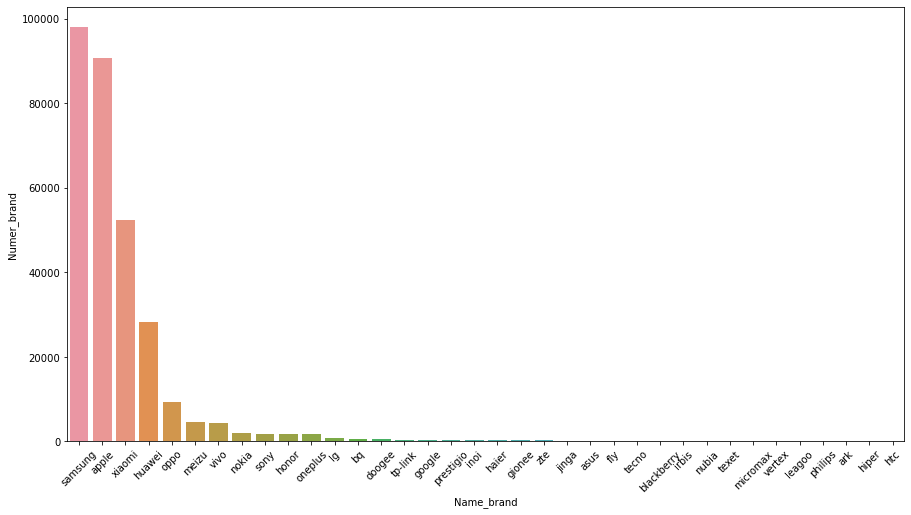

In [15]:
plt.figure(figsize = (15,8))
sns.barplot(x='brand', y='Numer_brand', data = df_brand)
plt.xlabel("Name_brand")
plt.ylabel("Numer_brand")
plt.xticks(rotation=45)
plt.show()

<h3>Có thể thấy các tên sản phẩm chủ lực được quan tâm nhiều nhất : Samsung, Apple, Xiaomi, Huawei..</h3>

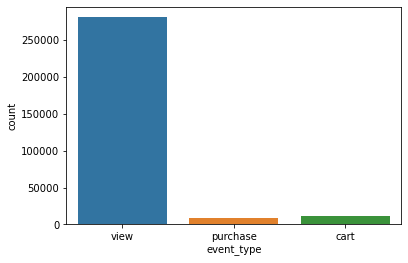

In [16]:
sns.countplot(x='event_type', data=df)

In [17]:
#df['date']=pd.to_datetime(df['event_time']).dt.strftime('%Y-%m-%d')

<h4>Đặt các thông số tương ứng để tiện xử lý. <h/4>

In [18]:
df['levels']=df['event_type'].map({'view':1, 'cart':2,'purchase':3})
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,levels
0,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,1
1,2019-10-01 00:00:11 UTC,view,1004545,2053013555631882655,electronics.smartphone,huawei,566.01,537918940,406c46ed-90a4-4787-a43b-59a410c1a5fb,1
2,2019-10-01 00:00:11 UTC,view,1005011,2053013555631882655,electronics.smartphone,samsung,900.64,530282093,50a293fb-5940-41b2-baf3-17af0e812101,1
3,2019-10-01 00:00:19 UTC,view,1005135,2053013555631882655,electronics.smartphone,apple,1747.79,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,1
4,2019-10-01 00:00:20 UTC,view,1003306,2053013555631882655,electronics.smartphone,apple,588.77,555446831,6ec635da-ea15-4a5d-96b4-c8ca9d38f89f,1


In [19]:
df_processing = df[['user_id','product_id','levels']]

In [20]:
df_processing.head()

,user_id,product_id,levels
0,535871217,1004237,1
1,537918940,1004545,1
2,530282093,1005011,1
3,535871217,1005135,1
4,555446831,1003306,1


<h4>Tạo ma trận giữa user và product dựa trên event type với những điểm dữ liệu bị miss thay thế bằng 0</h4>

In [21]:
matrix__=pd.pivot_table(df_processing,index='user_id',columns='product_id',values='levels').fillna(0.0)

In [22]:
matrix__.head()

product_id,1001588,1002042,1002062,1002098,1002099,1002100,1002101,1002102,1002225,1002367,...,1005163,1005164,1005165,1005166,1005167,1005168,1005169,1005171,1005172,1005178
user_id,,,,,,,,,,,,,,,,,,,,,
244951053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306087674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
337535108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
362972137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
365502652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h4>Nhân 2 ma trận với nhau để tạo ra ma trận tương quan giữa các product. </h4>

In [23]:
x = np.array(matrix__)
y = np.array(matrix__.T)
co_matrix = np.dot(y,x)
np.fill_diagonal(co_matrix, 0) # thay đường chéo chính bằng 0
df_co = pd.DataFrame(co_matrix,columns=matrix__.columns,index=matrix__.columns)
df_co

product_id,1001588,1002042,1002062,1002098,1002099,1002100,1002101,1002102,1002225,1002367,...,1005163,1005164,1005165,1005166,1005167,1005168,1005169,1005171,1005172,1005178
product_id,,,,,,,,,,,,,,,,,,,,,
1001588,0.0,0.0,0.0,1.00,0.00,0.00,1.00,0.00,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0
1002042,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
1002062,0.0,0.0,0.0,0.00,1.00,0.00,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
1002098,1.0,0.0,0.0,0.00,29.25,15.00,13.00,20.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.000000,4.000000,6.000000,1.0,3.0
1002099,0.0,0.0,1.0,29.25,0.00,43.25,44.25,63.25,0.0,1.0,...,0.0,1.0,3.4,1.0,0.0,19.000000,24.000000,17.000000,0.0,14.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005168,0.0,0.0,0.0,3.00,19.00,6.00,6.00,8.00,0.0,0.0,...,2.0,0.0,1.0,2.0,0.0,0.000000,25.166667,20.166667,0.0,4.0
1005169,0.0,0.0,0.0,4.00,24.00,6.00,6.00,6.00,0.0,0.0,...,1.0,0.0,3.0,3.0,1.0,25.166667,0.000000,21.000000,1.0,7.0
1005171,1.0,0.0,0.0,6.00,17.00,8.00,4.00,4.00,0.0,0.0,...,2.0,0.0,3.0,3.0,0.0,20.166667,21.000000,0.000000,0.0,2.0


In [24]:
def xLogX(x):
    return x * np.log(x) if x != 0 else 0.0

In [25]:
def entropy(x1, x2=0, x3=0, x4=0):
    return xLogX(x1 + x2 + x3 + x4) - xLogX(x1) - xLogX(x2) - xLogX(x3) - xLogX(x4)
def LLR(k11, k12, k21, k22):
    rowEntropy = entropy(k11 + k12, k21 + k22)
    columnEntropy = entropy(k11 + k21, k12 + k22)
    matrixEntropy = entropy(k11, k12, k21, k22)
    if rowEntropy + columnEntropy < matrixEntropy:
        return 0.0
    return 2.0 * (rowEntropy + columnEntropy - matrixEntropy)
def rootLLR(k11, k12, k21, k22):
    llr = LLR(k11, k12, k21, k22)
    sqrt = np.sqrt(llr)
    if k11 * 1.0 / (k11 + k12) < k21 * 1.0 / (k21 + k22):
        sqrt = -sqrt
    return sqrt

<h3>Hàm LLR tính toán khả năng xuất hiện của A và B cùng nhau.Trong đó:<br>
- k11 là số cả A và B cùng xuất hiện.<br>
- k12 là số B xuất hiện nhưng không có A.<br>
- k21 là số A xuất hiện nhưng không có B.<br>
- k22 cả A và B đều không xuất hiện.</h3>

In [26]:
row_sum = np.sum(co_matrix, axis=0)
column_sum = np.sum(co_matrix, axis=1)
total = np.sum(row_sum, axis=0)

In [27]:
pp_score = csr_matrix((co_matrix.shape[0], co_matrix.shape[1]), dtype='double')
s = coo_matrix(co_matrix)

In [28]:
for i,j,v in zip(s.row, s.col, s.data):
    if v != 0:
        k11 = v
        k12 = row_sum[i] - k11
        k21 = column_sum[j] - k11
        k22 = total - k11 - k12 - k21
        pp_score[i,j] = rootLLR(k11, k12, k21, k22)

In [29]:
df_item_recommend = pd.DataFrame(pp_score.A, columns = matrix__.columns, index = matrix__.columns)

In [30]:
co_matrix_1=np.array(df_item_recommend)
user_matrix_1 = np.dot(x, co_matrix_1)
idx_1 = pd.np.nonzero(x)
user_matrix_1[idx_1] = 0
df_user_recommend_1 = pd.DataFrame(user_matrix_1,columns = matrix__.columns,index = matrix__.index)


In [31]:
df_user_recommend_1.head()

product_id,1001588,1002042,1002062,1002098,1002099,1002100,1002101,1002102,1002225,1002367,...,1005163,1005164,1005165,1005166,1005167,1005168,1005169,1005171,1005172,1005178
user_id,,,,,,,,,,,,,,,,,,,,,
244951053,0.000000,0.000000,0.0,3.866584,7.161664,5.428055,4.752311,5.811521,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.296927,1.601332,-0.131536,0.703779,0.000000,1.288701
306087674,-2.159351,0.000000,0.0,1.773763,3.932568,1.881290,2.298922,2.176645,0.064454,-0.763863,...,-0.294962,-1.655081,-3.226026,-1.312597,-1.245190,0.269240,1.683331,1.465017,-1.052305,-0.847335
337535108,0.000000,0.000000,0.0,9.117120,20.949447,9.849471,9.341397,9.997108,0.000000,0.000000,...,0.000000,0.000000,-1.154684,-1.194133,-0.419556,3.287666,5.052068,6.509951,0.686024,3.056969
362972137,-1.113737,1.925271,0.0,-1.701722,4.649068,-1.313284,3.122781,-1.126329,0.344516,-0.507942,...,-0.603535,-4.383629,-3.535033,-5.770255,-1.745957,1.375724,1.945213,2.347192,-1.280718,-3.023329
365502652,0.000000,0.000000,0.0,0.000000,-1.814019,0.000000,-1.005112,-1.541513,0.000000,0.623564,...,2.918457,2.626405,6.163284,10.226575,2.386058,-1.830933,-2.514313,-0.904443,0.000000,-0.908905


In [32]:
def recommendations_from_occurence(user_id):
    df_09=df_user_recommend_1.loc[user_id].sort_values(ascending=False).head(5)
    df_10=df_09.reset_index()
    df_10=df_10.drop(user_id,1)
    df_10['user_id']=df_10['product_id']
    df_10['product_id']=user_id
    df_10.columns=['user_id','product_id']
    
    actions=[]
    real_indicators=[]
    for i in range(df_10.shape[0]):
        real_indicators.append(df_10.iloc[i][1].astype('int').tolist())
    data = {
        "id_user": user_id, 
        "product": real_indicators
        }
    actions.append(json.dumps(data))
    return actions
    


In [33]:
recommendations_from_occurence(244951053)

['{"id_user": 244951053, "product": [1003549, 1004530, 1004433, 1004529, 1004873]}']

<h2>Tương ứng với khách hàng có id: 244951053 ta có thể recomment các sản phẩm có ID:[1003549, 1004530, 1004433, 1004529, 1004873].</h2>